## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    print(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

camera_cal/calibration5.jpg
camera_cal/calibration4.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration3.jpg
camera_cal/calibration2.jpg
camera_cal/calibration1.jpg
camera_cal/calibration20.jpg
camera_cal/calibration19.jpg
camera_cal/calibration18.jpg
camera_cal/calibration15.jpg
camera_cal/calibration14.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration13.jpg
camera_cal/calibration12.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration9.jpg
camera_cal/calibration8.jpg


In [9]:
print(objp.shape)
print(corners.shape)

(54, 3)
(54, 1, 2)


In [10]:
yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])

white_low = np.array([18,0,180])
white_high = np.array([255,80,255])

In [11]:
#Camera calibration matrices
img = cv2.imread("camera_cal/calibration2.jpg")
img_size = (img.shape[1], img.shape[0])
print(img_size)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

(1280, 720)


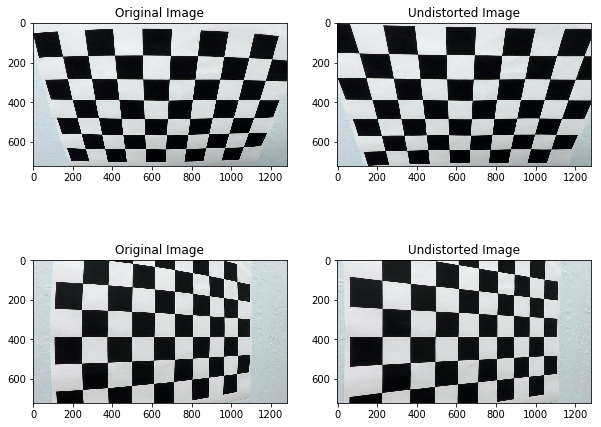

In [12]:
#Examples of undistorted image
%matplotlib inline
plt.figure(figsize=(10,8))

img = cv2.imread("camera_cal/calibration2.jpg")
img2 = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(2,2,1)
plt.title('Original Image')
fig =plt.imshow(img)

plt.subplot(2,2,2)
plt.title('Undistorted Image')
fig =plt.imshow(img2)


img = cv2.imread("camera_cal/calibration5.jpg")
img2 = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(2,2,3)
plt.title('Original Image')
fig =plt.imshow(img)

plt.subplot(2,2,4)
plt.title('Undistorted Image')
fig =plt.imshow(img2)

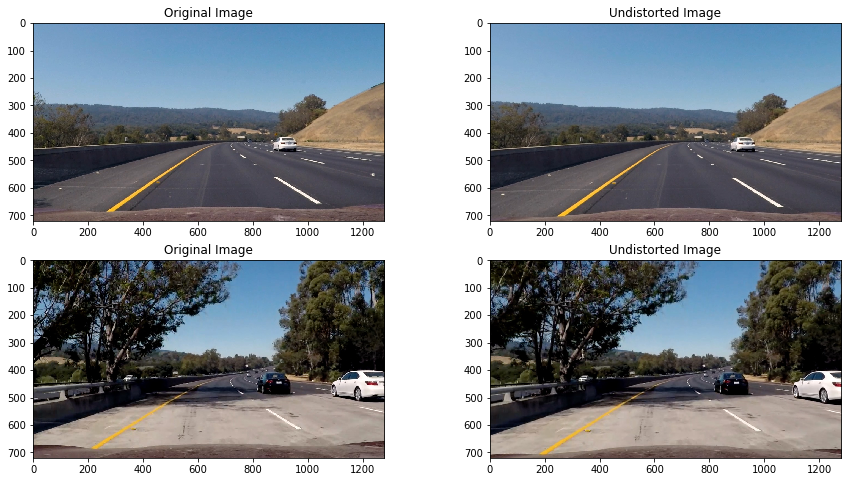

In [14]:

plt.figure(figsize=(15,8))

img = cv2.imread("test_images/test3.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.undistort(imgRGB, mtx, dist, None, mtx)
plt.subplot(2,2,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)

plt.subplot(2,2,2)
plt.title('Undistorted Image')
fig =plt.imshow(img2)


img = cv2.imread("test_images/test5.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.undistort(imgRGB, mtx, dist, None, mtx)

plt.subplot(2,2,3)
plt.title('Original Image')
fig =plt.imshow(imgRGB)

plt.subplot(2,2,4)
plt.title('Undistorted Image')
fig =plt.imshow(img2)

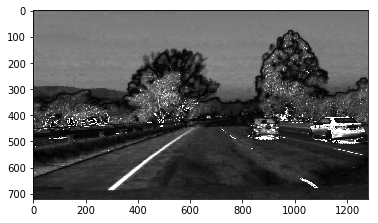

In [68]:
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
plt.imshow(hls[:, :, 2], cmap='gray')

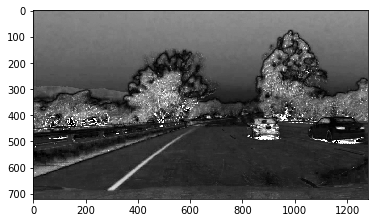

In [72]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(hsv[:, :, 1], cmap='gray')

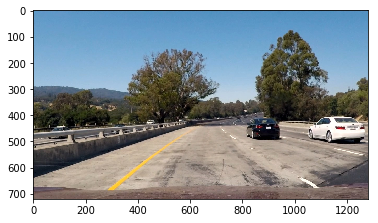

In [55]:
plt.imshow(imgRGB)

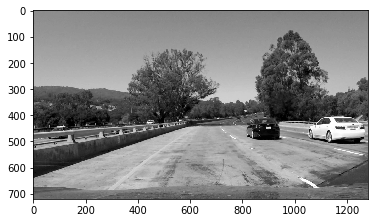

In [66]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [15]:
def hls_color_thresh(img, threshLow, threshHigh):
    # 1) Convert to HLS color space
    #imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #Hue (0,180) Light (0,255), satur (0,255)

   
    # 3) Return a binary image of threshold result
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    #binary_output[(imgHLS[:,:,0] >= threshH[0]) & (imgHLS[:,:,0] <= threshH[1]) & (imgHLS[:,:,1] >= threshL[0]) & (imgHLS[:,:,1] <= threshL[1])  | ((imgHLS[:,:,2] >= threshS[0]) & (imgHLS[:,:,2] <= threshS[1]))] = 1
    binary_output[(imgHLS[:,:,0] >= threshLow[0]) & (imgHLS[:,:,0] <= threshHigh[0]) & (imgHLS[:,:,1] >= threshLow[1])  & (imgHLS[:,:,1] <= threshHigh[1])  & (imgHLS[:,:,2] >= threshLow[2]) & (imgHLS[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output

In [95]:
#Magnitude threshold
def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):
    # Apply the following steps to img
    # 1) Convert to grayscale
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Take the gradient in x and y separately
    #Channels L and S from HLS
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    # 5) Create a binary mask where mag thresholds are met
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    # 6) Return this mask as your binary_output image
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1


    # 6) Return this mask as your binary_output image
    return binary_output


#Direction threshold
def dir_threshold(img, img_type='gray', sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     if img_type == 'gray':
#         tmp = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         sobelx = cv2.Sobel(tmp, cv2.CV_64F, 1,0, ksize=sobel_kernel)
#         sobely = cv2.Sobel(tmp, cv2.CV_64F, 0,1, ksize=sobel_kernel)
#     elif img_type == 'hls':
#         tmp = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         sobelx = cv2.Sobel(tmp[:, :, 2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
#         sobely = cv2.Sobel(tmp[:, :, 2], cv2.CV_64F, 0,1, ksize=sobel_kernel)
#     elif img_type == 'hsv':
#         tmp = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         sobelx = cv2.Sobel(tmp[:, :, 1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
#         sobely = cv2.Sobel(tmp[:, :, 1], cv2.CV_64F, 0,1, ksize=sobel_kernel)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

#Both Magnitude and direction threshold
def mag_dir_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    #Calc angle
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))
       
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ] = 1


    # 6) Return this mask as your binary_output image
    return binary_output

Examples of color thresholds


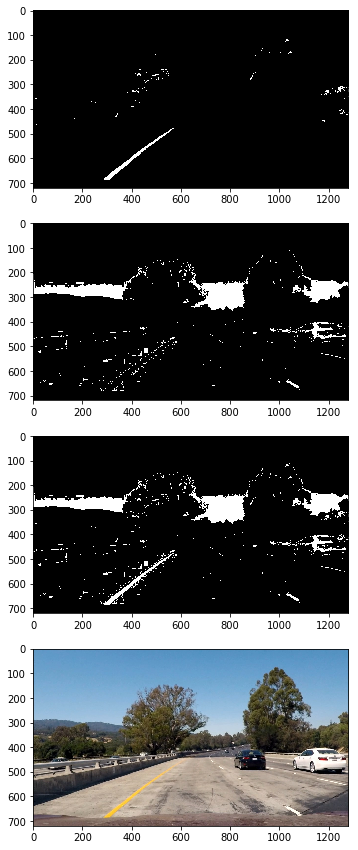

In [96]:
#Examples of color thresholds

img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#imgHLS = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
#print(np.max(imgHLS[:,:,0]))

print("Examples of color thresholds")

yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])

white_low = np.array([18,0,180])
white_high = np.array([255,80,255])


imgThres_yellow = hls_color_thresh(imgRGB,yellow_low,yellow_high)
imgThres_white = hls_color_thresh(imgRGB,white_low,white_high)


imgThres_both =np.zeros_like(imgThres_yellow)

imgThres_both[(imgThres_yellow==1) | (imgThres_white==1)] =1

plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
plt.imshow(imgThres_yellow,cmap ='gray')
plt.subplot(4,1,2)
plt.imshow(imgThres_white,cmap ='gray')

plt.subplot(4,1,3)
plt.imshow(imgThres_both,cmap ='gray')
           
plt.subplot(4,1,4)
plt.imshow(imgRGB)


Examples of magnitude and direction thresholds


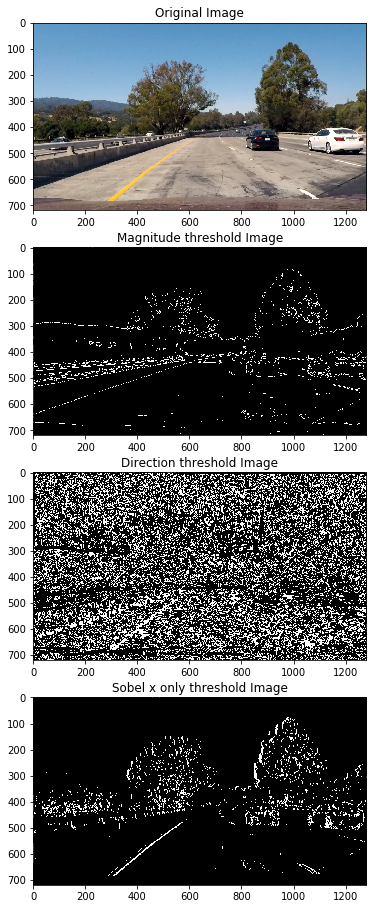

In [105]:
#Examples of magnitude and direction thresholds
plt.figure(figsize=(10,8))

img = cv2.imread("test_images/test1.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

magThr =mag_thresh(imgRGB, 3, (50, 100))
#imgDirThr =dir_threshold(img, 9,(np.pi/2*30/90, np.pi/2*60/90))
#magThr =mag_dir_thresh(imgRGB, 9, (100,255)) #Only magnitude

dirThr = dir_threshold(imgRGB, 'hls', 31, (np.pi/4, np.pi/2.5))
#dirThr =mag_dir_thresh(imgRGB, 9,(50,100) ,(np.pi/2*30/90, np.pi/2*60/90))
#Only direction
#imgThr =mag_dir_thresh(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 9, (30, 255),(np.pi/2*60/90, np.pi/2*120/90)) #Both

#Sobel x only
imgThr = sobel_x(imgRGB,9,80,220) #Sobel x

print("Examples of magnitude and direction thresholds")
plt.figure(figsize=(30,20))

plt.subplot(5,1,1)
plt.title('Original Image')
fig =plt.imshow(imgRGB)

plt.subplot(5,1,2)
plt.title('Magnitude threshold Image')
fig =plt.imshow(magThr,cmap = 'gray')

plt.subplot(5,1,3)
plt.title('Direction threshold Image')
fig =plt.imshow(dirThr,cmap = 'gray')

plt.subplot(5,1,4)
plt.title('Sobel x only threshold Image')
fig =plt.imshow(imgThr,cmap = 'gray')


#imgThresColor = hls_color_thresh(imgRGB,(20,30),(150,255),(200,255))
#imgThr =mag_dir_thresh(imgThresColor, 3, (30, 255),(np.pi/2*50/90, np.pi/2*90/90)) #Both

#plt.subplot(5,1,5)
#plt.title('Color and threshold Image')
#fig =plt.imshow(imgThr,cmap = 'gray')

720 1280


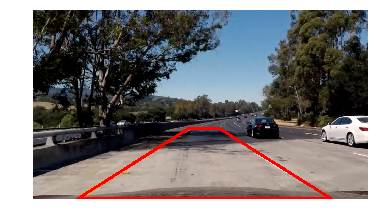

In [128]:
copy_combined = np.copy(img2)
# print(copy_combined.shape)
# (bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
row, col = copy_combined.shape[:2]
print(row, col)
pts = np.array([[170, row - 1],[595,450],[710,450], [1140, row - 1]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [120]:
def compute_perspective_transform_matrices(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return M, M_inv

In [121]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [123]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, row - 1], [200, 0], [1000, 0], [1000, row - 1]], np.float32)

In [129]:
test_img_persp_tr = perspective_transform(img2, src_pts, dst_pts)

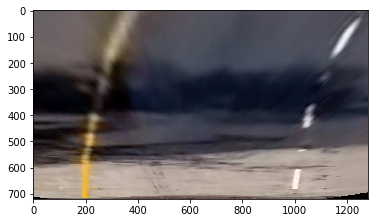

In [244]:
plt.imshow(test_img_persp_tr)
# plt.savefig('perspective_transform')

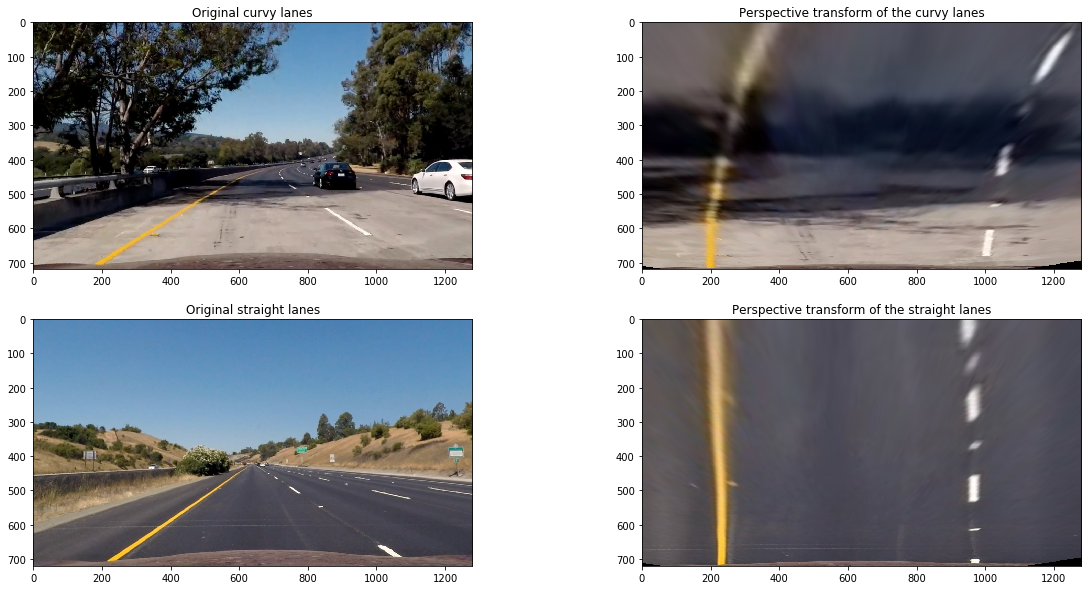

In [253]:
straight = cv2.imread('test_images/straight_lines1.jpg')
# plt.imshow(straight)
straightRGB = cv2.cvtColor(straight, cv2.COLOR_BGR2RGB)
straight = cv2.undistort(straightRGB, mtx, dist, None, mtx)
straight_persp_tr = perspective_transform(straight, src_pts, dst_pts)
fig3, ax3 = plt.subplots(2, 2, figsize=(20, 10))
ax3[0][0].imshow(img2)
ax3[0][0].set_title('Original curvy lanes')
ax3[0][1].imshow(test_img_persp_tr)
ax3[0][1].set_title('Perspective transform of the curvy lanes')
ax3[1][0].imshow(straight)
ax3[1][0].set_title('Original straight lanes')
ax3[1][1].imshow(straight_persp_tr)
ax3[1][1].set_title('Perspective transform of the straight lanes')
plt.savefig('perspective_transform')

In [257]:
from utils import *

In [213]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.undistort(image, mtx, dist, None, mtx)

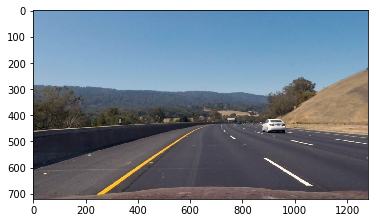

In [214]:
plt.imshow(image)

In [215]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

In [216]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

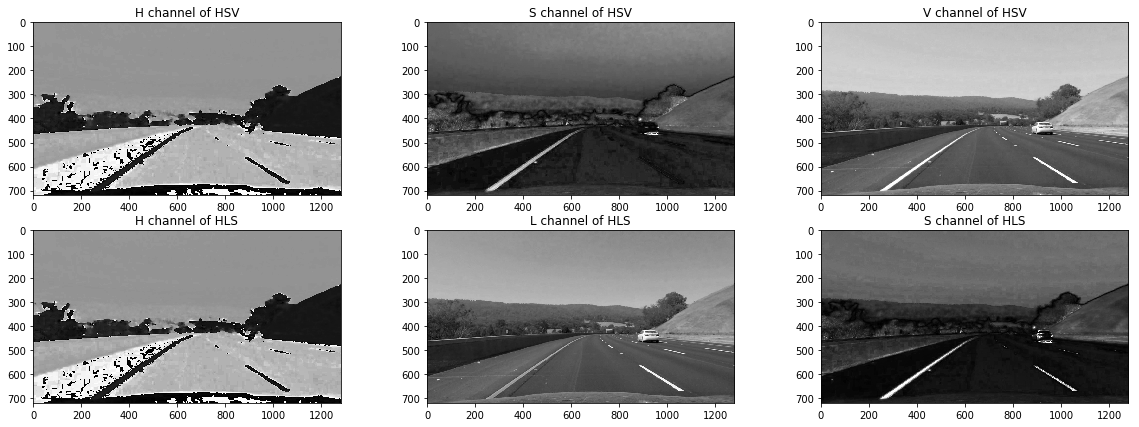

In [217]:
fig, ax = plt.subplots(2, 3, figsize=(20, 7))
ax[0][0].imshow(hsv[:, :, 0], cmap='gray')
ax[0][1].imshow(hsv[:, :, 1], cmap='gray')
ax[0][2].imshow(hsv[:, :, 2], cmap='gray')
ax[1][0].imshow(hls[:, :, 0], cmap='gray')
ax[1][1].imshow(hls[:, :, 1], cmap='gray')
ax[1][2].imshow(hls[:, :, 2], cmap='gray')
ax[0][0].set_title('H channel of HSV')
ax[0][1].set_title('S channel of HSV')
ax[0][2].set_title('V channel of HSV')
ax[1][0].set_title('H channel of HLS')
ax[1][1].set_title('L channel of HLS')
ax[1][2].set_title('S channel of HLS')
fig.savefig('hsv_vs_hls')

In [218]:
ax[0][1].imshow(hsv[:, :, 0], cmap='gray')

In [219]:
yellow_low = np.array([0,100,100])
yellow_high = np.array([50,255,255])

white_low = np.array([18,0,180])
white_high = np.array([255,80,255])

In [220]:
yellow_masked_image = hls_color_thresh(image, yellow_low, yellow_high)

In [221]:
white_masked_image = hls_color_thresh(image, white_low, white_high)

In [222]:
image_masked = np.zeros_like(yellow_masked_image)

In [223]:
image_masked[(yellow_masked_image == 1) | (white_masked_image == 1)] = 1

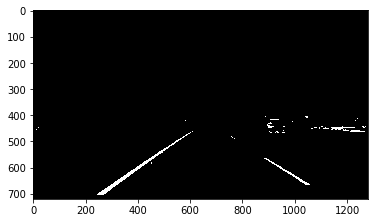

In [224]:
plt.imshow(image_masked, cmap='gray')
plt.savefig('yw_masked')

575.0


/Users/hpnhxxwn/Desktop/proj/udacity/CarND-Advanced-Lane-Lines/utils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  m = np.arctan(abs_sobely/abs_sobelx)
/Users/hpnhxxwn/Desktop/proj/udacity/CarND-Advanced-Lane-Lines/utils.py:72: RuntimeWarning: invalid value encountered in true_divide
  m = np.arctan(abs_sobely/abs_sobelx)
/Users/hpnhxxwn/Desktop/proj/udacity/CarND-Advanced-Lane-Lines/utils.py:77: RuntimeWarning: invalid value encountered in greater
  binary_output[(m > thresh[0]) & (m < thresh[1])] = 1
/Users/hpnhxxwn/Desktop/proj/udacity/CarND-Advanced-Lane-Lines/utils.py:77: RuntimeWarning: invalid value encountered in less
  binary_output[(m > thresh[0]) & (m < thresh[1])] = 1


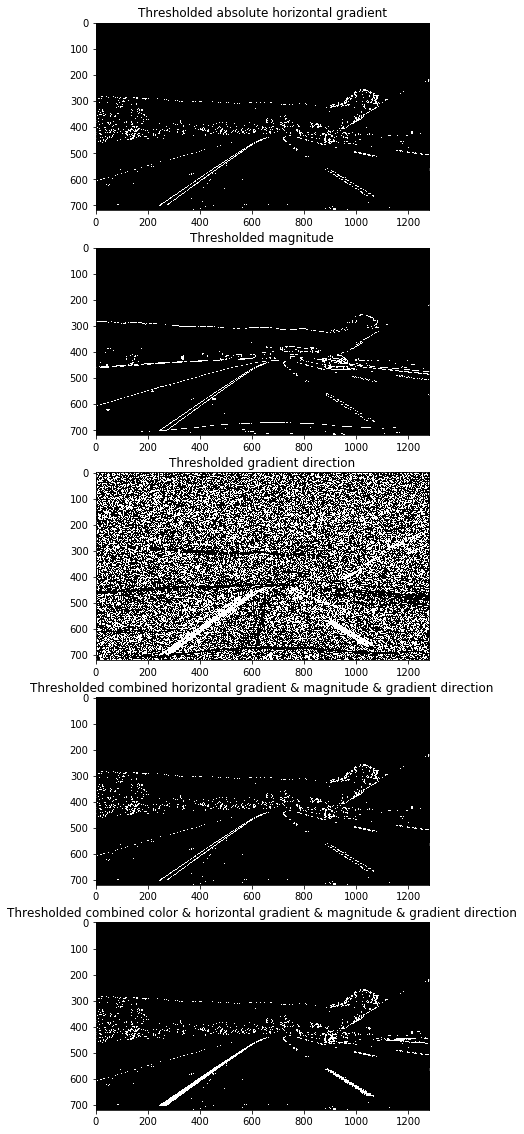

In [242]:
fig2, ax2 = plt.subplots(5, 1, figsize=(20, 20))
abs_bin = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=120)
mag_bin = mag_thresh(image, sobel_kernel=3, mag_thresh=(40, 150))
dir_bin = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_bin)
combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1)))] = 1
ax2[0].imshow(abs_bin, cmap='gray')
ax2[1].imshow(mag_bin, cmap='gray')
ax2[2].imshow(dir_bin, cmap='gray')
ax2[3].imshow(combined, cmap='gray')
combined[(yellow_masked_image == 1) | (white_masked_image == 1)] = 1
ax2[4].imshow(combined, cmap='gray')
ax2[0].set_title('Thresholded absolute horizontal gradient')
ax2[1].set_title('Thresholded magnitude')
ax2[2].set_title('Thresholded gradient direction')
ax2[3].set_title('Thresholded combined horizontal gradient & magnitude & gradient direction')
ax2[4].set_title('Thresholded combined color & horizontal gradient & magnitude & gradient direction')
plt.savefig('thresholded_figs')

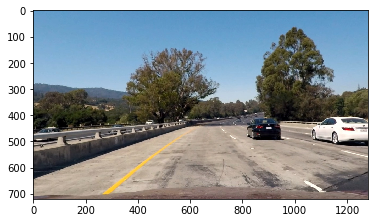

In [194]:
plt.imshow(image)

In [254]:
import matplotlib.image as mpimg

In [259]:
from fit_line import fit_line, fit_tune, final_viz, calc_curve, calc_vehicle_offset
from gen_video import *
def combined_thresh(img):
        yellow_low = np.array([0,100,100])
        yellow_high = np.array([50,255,255])

        white_low = np.array([18,0,180])
        white_high = np.array([255,80,255])
        imgThres_yellow = hls_color_thresh(img,yellow_low,yellow_high)
        imgThres_white = hls_color_thresh(img,white_low,white_high)
        abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
        mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
        dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
        # hls_bin = hls_thresh(img, thresh=(170, 255))

        combined = np.zeros_like(dir_bin)
        combined[(imgThres_yellow==1) | (imgThres_white==1)] = 1
        combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1)))] = 1

        return combined, abs_bin, mag_bin, dir_bin, imgThres_yellow, imgThres_white
    
result = annotate_image(image)

498.0


ValueError: not enough values to unpack (expected 6, got 5)